In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.cm as cm
%matplotlib inline
import cmocean
import plotting
from takeout import monthly_means_annual

import copy

In [2]:
# constant declarations
#lat1 < lat2
lat1 = -20
lat2 = 20

lat_lims = [lat1,lat2]

#variable files on disk
omega_file = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/w/w.nc'
omega_file_full = '/home/jakidxav/Desktop/work_hartmann/erai_monthly/mergeFiles/w_7917.nc'


lon_list = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 239]
lon_list_labels = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5]

lon_list_small = [80, 100, 120, 140, 160, 180]
lon_list_labels_small = [120., 150., 180., 210., 240., 270.]

shifted_lon_list = [60, 80, 100, 120, 140, 160, 180, 200, 220, 239, 0, 20, 40]
shifted_lon_list_labels = [90, 120, 150, 180, 210, 240, 270, 300, 330, 358.5, 0, 30, 60]
shifted_labels_eastWest = ['90E', '120E', '150E', '180', '150W', '120W', '90W', '60W', '30W', '0', '30E', '60E', '90E']

yr_ticks = np.arange(1, 468, 12)
p_tick_list = [0, 1, 5, 8, 12, 16, 28]
p_list = [70, 100, 200, 300, 500, 700, 1000]
z_list = [5, 10, 15, 20, 25]

#for plotting
vmin = -0.08
vmax = 0.085
contours = np.arange(vmin, vmax, 0.005)

colormap = cmocean.cm.balance
colorbar_label = r"$Pa \hspace{1} s^{-1}$"

left_title_diff = '[$-\omega + \omega$]'

#It is actually omega, but weighted for regions where it is upward(or negative) between x˚S and x˚N.
right_title_diff = '1989-2007'
right_title_diff_full = '1979-2017'

#axis labels
p_label = 'Pressure (mb)'
z_label = 'Height (km)'

figure_name_diff = 'lon_omegaDifference_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'area_weight_avg.pdf'
figure_name_diff_full = 'lon_omegaDifference_'+str(lat_lims[0])+'_'+str(lat_lims[1])+'_'+'area_weight_avg_AllYears.pdf'

### Data Import

In [3]:
#read in data files
#omega is in hPa NOT Pa
omega_data = nc.Dataset(omega_file_full)

#process variables
omega = omega_data.variables['w'][:]

lon  = omega_data.variables['longitude'][:]
lat  = omega_data.variables['latitude'][:]
dumb_time = omega_data.variables['time'][:]
#shortened file: levelist, full file: level
p = omega_data.variables['level'][:]

#convert time to more user-friendly format
time = pd.to_datetime(dumb_time, unit='h',
                       origin=pd.Timestamp('1900-01-01'))

#for boolean indexing
latidx = (lat >=lat_lims[0] ) & (lat <=lat_lims[1] )

#only take pressures greater than 10hPa (for plotting purposes)
pidx = 21

#subset new tensors for correct latitude, pressure ranges
omega_lat = omega[:, :, latidx, :]
omega_lat_p = omega_lat[:, pidx, :, :]

year_list = list(time.year)
count = 0
for yr in np.arange(1979, 2018):
    for i in np.arange(0, 12):
        add = np.round(i / 12.0, 3)
        #print(yr, i, count, add)
        year_list[count] += add
        count += 1

In [4]:
print(np.shape(omega_lat_p))

(468, 27, 240)


In [5]:
#create monthly means for normalization
#monthly_means = monthly_means_annual(omega_lat_p, time)
jan_avg = np.nanmean(omega_lat_p[time.month==1], axis=0)
feb_avg = np.nanmean(omega_lat_p[time.month==2], axis=0)
mar_avg = np.nanmean(omega_lat_p[time.month==3], axis=0)
apr_avg = np.nanmean(omega_lat_p[time.month==4], axis=0)
may_avg = np.nanmean(omega_lat_p[time.month==5], axis=0)
jun_avg = np.nanmean(omega_lat_p[time.month==6], axis=0)
jul_avg = np.nanmean(omega_lat_p[time.month==7], axis=0)
aug_avg = np.nanmean(omega_lat_p[time.month==8], axis=0)
sep_avg = np.nanmean(omega_lat_p[time.month==9], axis=0)
oct_avg = np.nanmean(omega_lat_p[time.month==10], axis=0)
nov_avg = np.nanmean(omega_lat_p[time.month==11], axis=0)
dec_avg = np.nanmean(omega_lat_p[time.month==12], axis=0)
    
monthly_means_allYear = [jan_avg, feb_avg, mar_avg, apr_avg, may_avg, jun_avg, jul_avg, aug_avg, sep_avg, oct_avg, nov_avg, dec_avg]

In [7]:
print(np.shape(monthly_means_allYear))
print(np.shape(monthly_means_allYear[0]))

(12, 27, 240)
(27, 240)


In [9]:
#normalize omega data, subtract monthly means
normalized = copy.deepcopy(omega_lat_p)
count = 1
for i in np.arange(1979, 2018):
    for j in np.arange(1, 13):
        month = time[count-1].month - 1
        print(i, j, time[count-1].month, month)
        #normalized[count-1] will have shape(27, 240)
        normalized[count-1] = normalized[count-1] - monthly_means_allYear[month]
        count = count + 1

1979 1 1 0
1979 2 2 1
1979 3 3 2
1979 4 4 3
1979 5 5 4
1979 6 6 5
1979 7 7 6
1979 8 8 7
1979 9 9 8
1979 10 10 9
1979 11 11 10
1979 12 12 11
1980 1 1 0
1980 2 2 1
1980 3 3 2
1980 4 4 3
1980 5 5 4
1980 6 6 5
1980 7 7 6
1980 8 8 7
1980 9 9 8
1980 10 10 9
1980 11 11 10
1980 12 12 11
1981 1 1 0
1981 2 2 1
1981 3 3 2
1981 4 4 3
1981 5 5 4
1981 6 6 5
1981 7 7 6
1981 8 8 7
1981 9 9 8
1981 10 10 9
1981 11 11 10
1981 12 12 11
1982 1 1 0
1982 2 2 1
1982 3 3 2
1982 4 4 3
1982 5 5 4
1982 6 6 5
1982 7 7 6
1982 8 8 7
1982 9 9 8
1982 10 10 9
1982 11 11 10
1982 12 12 11
1983 1 1 0
1983 2 2 1
1983 3 3 2
1983 4 4 3
1983 5 5 4
1983 6 6 5
1983 7 7 6
1983 8 8 7
1983 9 9 8
1983 10 10 9
1983 11 11 10
1983 12 12 11
1984 1 1 0
1984 2 2 1
1984 3 3 2
1984 4 4 3
1984 5 5 4
1984 6 6 5
1984 7 7 6
1984 8 8 7
1984 9 9 8
1984 10 10 9
1984 11 11 10
1984 12 12 11
1985 1 1 0
1985 2 2 1
1985 3 3 2
1985 4 4 3
1985 5 5 4
1985 6 6 5
1985 7 7 6
1985 8 8 7
1985 9 9 8
1985 10 10 9
1985 11 11 10
1985 12 12 11
1986 1 1 0
1986 2 2 

In [10]:
#create cos(lat) matrix
cos_lat = np.asmatrix(np.cos(np.deg2rad(lat[latidx]))).T
cos_lat_matrix = np.multiply(np.ones((27,240)), cos_lat)

#weight by cos(lat)
omega_weight = np.multiply(omega_lat_p, cos_lat_matrix)
norm_weight = np.multiply(normalized, cos_lat_matrix)

omega_latmean = np.mean(omega_weight, axis=1)
norm_latmean = np.mean(norm_weight, axis=1)

In [11]:
print(np.shape(norm_latmean))

print(np.max(omega_latmean))
print(np.min(omega_latmean))
print()

print(np.max(norm_latmean))
print(np.min(norm_latmean))

(468, 240)
0.03631960676796559
-0.07826150745059807

0.04639905745172682
-0.05664751040266386


<Figure size 720x64800 with 0 Axes>

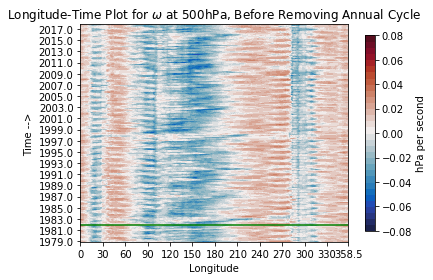

<Figure size 720x64800 with 0 Axes>

In [12]:
Norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
contour = plt.contourf(omega_latmean, contours, cmap=colormap, norm=Norm)
cbar = plt.colorbar(shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time -->')

plt.axhline(y = 37, color='g')
plt.title('Longitude-Time Plot for $\omega$ at 500hPa, Before Removing Annual Cycle')
plt.figure(figsize=(10,900))
#plt.savefig('latTime_preRemoval.png', format='png')
#plt.show()

<Figure size 720x64800 with 0 Axes>

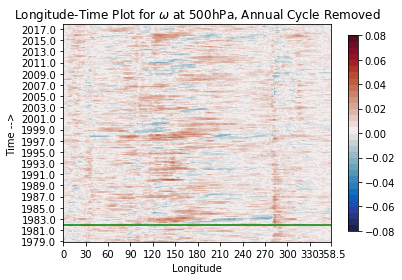

<Figure size 720x64800 with 0 Axes>

In [13]:
contour2 = plt.contourf(norm_latmean, contours, cmap=colormap, norm=Norm)
cbar2 = plt.colorbar(shrink=0.9)
cbar.set_label('hPa per second')

plt.xticks(lon_list, labels=lon_list_labels)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time -->')

plt.axhline(y = 37, color='g')
plt.title('Longitude-Time Plot for $\omega$ at 500hPa, Annual Cycle Removed')
plt.figure(figsize=(10,900))
#plt.savefig('latTime_removeCycle.png', format='png')
#plt.show()

<Figure size 720x64800 with 0 Axes>

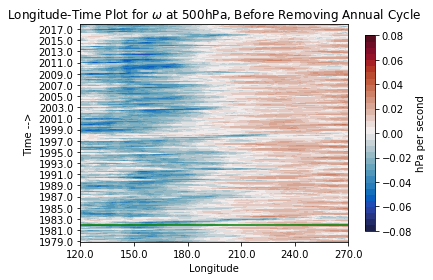

<Figure size 720x64800 with 0 Axes>

In [14]:
contour2 = plt.contourf(omega_latmean[:, 80:181], contours, cmap=colormap, norm=Norm)
cbar2 = plt.colorbar(shrink=0.9)
cbar2.set_label('hPa per second')

plt.xticks([0, 20, 40, 60, 80, 100], labels=lon_list_labels_small)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time -->')

plt.axhline(y = 37, color='g')
plt.title('Longitude-Time Plot for $\omega$ at 500hPa, Before Removing Annual Cycle')
plt.figure(figsize=(10,900))
#plt.savefig('latTime_preRemoval_pacific.png', format='png')
#plt.show()

<Figure size 720x64800 with 0 Axes>

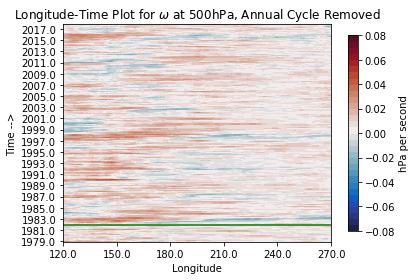

<Figure size 720x64800 with 0 Axes>

In [15]:
contour2 = plt.contourf(norm_latmean[:, 80:181], contours, cmap=colormap, norm=Norm)
cbar2 = plt.colorbar(shrink=0.9)
cbar2.set_label('hPa per second')

plt.xticks([0, 20, 40, 60, 80, 100], labels=lon_list_labels_small)
plt.xlabel('Longitude')

plt.yticks(yr_ticks[::2], labels=year_list[::24])
plt.ylabel('Time -->')

plt.axhline(y = 37, color='g')
plt.title('Longitude-Time Plot for $\omega$ at 500hPa, Annual Cycle Removed')
plt.figure(figsize=(10,900))
#plt.savefig('latTime_removeCycle_pacific.png', format='png')
#plt.show()